In [1]:
import warnings
import pandas as pd
from utils import make_dataset
warnings.filterwarnings("ignore")

data = make_dataset()

100%|██████████| 30109/30109 [00:02<00:00, 12642.04it/s]


In [2]:
%%time
import nltk
from bs4 import BeautifulSoup
from string import punctuation
from urlextract import URLExtract
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import TweetTokenizer
from sklearn.feature_extraction.text import TfidfVectorizer

STOP_WORDS = set(stopwords.words('english'))
STOP_WORDS |= {'hou', 'ect', 'etc'}
ENTITY_TAG = "<PROPN>"
SUPPORTED_POS = {"N", "V", "J", "R"}
PUNCTUATION = set(punctuation) | {"_", '-', '+'}

tknzr = TweetTokenizer()
lm = WordNetLemmatizer()
tfidf = TfidfVectorizer(
    ngram_range=(1, 3),
    min_df=5,
    max_df=0.8,
    tokenizer=tknzr.tokenize
)
url_extractor = URLExtract()


def get_wordnet_pos(treebank_tag):

    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return 'n'

def text_preparation(s):
    s = BeautifulSoup(s).text
    urls = []
    try:
        urls = url_extractor.find_urls(s)
    except:
        pass
    tokens = tknzr.tokenize(s)
    
    tokens = [
        token for token in tokens if (
            len(token) > 2
            and
            not "@" in token
            and
            not token.isnumeric()
            and
            not token in PUNCTUATION
            and
            not token in urls
        )
    ]
    tokens = [token.lower() for token in tokens if not len(set(token.lower().split("'")) & STOP_WORDS)]

    
    poss = nltk.pos_tag(tokens)
    
    tokens1 = []
    for token, pos in poss:
        for sup_pos in SUPPORTED_POS:
            if sup_pos in pos:
                tokens1.append(
                    lm.lemmatize(
                        token,
                        pos=get_wordnet_pos(pos)
                    )
                )
                break
    
    s = " ".join(tokens1)
    return s

CPU times: user 718 ms, sys: 622 ms, total: 1.34 s
Wall time: 575 ms


In [3]:
%%time
data['text'] = data['text'].apply(text_preparation)
data['subject'] = data['subject'].apply(text_preparation)

CPU times: user 2min 16s, sys: 583 ms, total: 2min 16s
Wall time: 2min 16s


In [4]:
data.head()

,date,subject,from,to,text,path
11433,1999-12-10 05:05:00,tetco,chris.germany@enron.com,judy.townsend@enron.com,update tetco usage ticket include fuel,../data/maildir/germany-c/_sent_mail/1875.
11432,1999-12-10 05:05:00,tetco,chris.germany@enron.com,brenda.fletcher@enron.com,update tetco usage ticket include fuel,../data/maildir/germany-c/_sent_mail/1875.
18894,1999-12-10 05:12:00,new eprm speaker,vince.kaminski@enron.com,stinson.gibner@enron.com,stinson request get risk vince,../data/maildir/kaminski-v/_sent_mail/4809.
18893,1999-12-10 05:13:00,new eprm speaker,vince.kaminski@enron.com,helen@risk.co.uk,helen forward message associate stinson gibner...,../data/maildir/kaminski-v/_sent_mail/4808.
304,1999-12-10 07:00:00,,phillip.allen@enron.com,naomi.johnston@enron.com,naomi analyst contact matt lenhart vishal apte...,../data/maildir/allen-p/_sent_mail/345.


In [5]:
data.to_csv("enron_prepared.csv")

In [6]:
import warnings
import pandas as pd
warnings.filterwarnings("ignore")
data = pd.read_csv("enron_prepared.csv", index_col=0)
data.fillna('', inplace=True)
data.head()

,date,subject,from,to,text,path
11433,1999-12-10 05:05:00,tetco,chris.germany@enron.com,judy.townsend@enron.com,update tetco usage ticket include fuel,../data/maildir/germany-c/_sent_mail/1875.
11432,1999-12-10 05:05:00,tetco,chris.germany@enron.com,brenda.fletcher@enron.com,update tetco usage ticket include fuel,../data/maildir/germany-c/_sent_mail/1875.
18894,1999-12-10 05:12:00,new eprm speaker,vince.kaminski@enron.com,stinson.gibner@enron.com,stinson request get risk vince,../data/maildir/kaminski-v/_sent_mail/4809.
18893,1999-12-10 05:13:00,new eprm speaker,vince.kaminski@enron.com,helen@risk.co.uk,helen forward message associate stinson gibner...,../data/maildir/kaminski-v/_sent_mail/4808.
304,1999-12-10 07:00:00,,phillip.allen@enron.com,naomi.johnston@enron.com,naomi analyst contact matt lenhart vishal apte...,../data/maildir/allen-p/_sent_mail/345.


In [7]:
from nltk.tokenize import TweetTokenizer
tknzr = TweetTokenizer()

In [8]:
texts = pd.Series(data['text'].unique()).apply(tknzr.tokenize).tolist()

In [9]:
%%time
from gensim import corpora, models
id2word = corpora.Dictionary(texts)
id2word.filter_extremes(no_below=5, no_above=0.8)

bigram = models.Phrases(texts)
trigram = models.Phrases(bigram[texts])

bigram_mod = models.phrases.Phraser(bigram)
trigram_mod = models.phrases.Phraser(trigram)


def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]


CPU times: user 25.5 s, sys: 79.9 ms, total: 25.6 s
Wall time: 25.6 s


In [10]:
%%time
trigrams = make_trigrams(texts)

CPU times: user 6.14 s, sys: 24.1 ms, total: 6.16 s
Wall time: 6.16 s


In [11]:
id2word = corpora.Dictionary(trigrams)
corpus = [id2word.doc2bow(text) for text in trigrams]

In [19]:
len(id2word)

53438

100%|██████████| 33/33 [1:25:57<00:00, 156.29s/it]

Num Topics = 2  has Coherence Value of 0.4658
Num Topics = 3  has Coherence Value of 0.4652
Num Topics = 4  has Coherence Value of 0.4592
Num Topics = 5  has Coherence Value of 0.448
Num Topics = 6  has Coherence Value of 0.4808
Num Topics = 7  has Coherence Value of 0.4788
Num Topics = 8  has Coherence Value of 0.4948
Num Topics = 9  has Coherence Value of 0.5044
Num Topics = 10  has Coherence Value of 0.4972
Num Topics = 11  has Coherence Value of 0.4705
Num Topics = 12  has Coherence Value of 0.4838
Num Topics = 13  has Coherence Value of 0.5128
Num Topics = 14  has Coherence Value of 0.5186
Num Topics = 15  has Coherence Value of 0.5214
Num Topics = 16  has Coherence Value of 0.5009
Num Topics = 17  has Coherence Value of 0.5073
Num Topics = 18  has Coherence Value of 0.5015
Num Topics = 19  has Coherence Value of 0.481
Num Topics = 20  has Coherence Value of 0.4822
Num Topics = 21  has Coherence Value of 0.4716
Num Topics = 22  has Coherence Value of 0.4731
Num Topics = 23  has Co

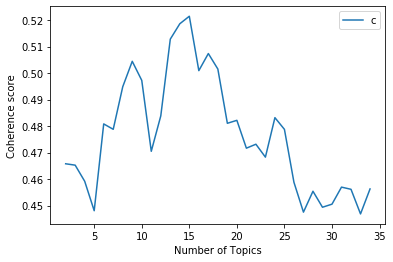

CPU times: user 1h 17min 50s, sys: 59min 18s, total: 2h 17min 9s
Wall time: 1h 25min 57s


In [24]:
%%time
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

# Find the optimal number of topics
START = 2
LIMIT = 35
STEP = 1
topic_range = list(range(START, LIMIT, STEP))

coherence_values = []
model_list = []

for num_topics in tqdm(topic_range):
    model = models.LdaMulticore(
        corpus=corpus, 
        id2word=id2word, 
        num_topics=num_topics, 
        workers=11,
        passes=20,
        random_state=100500,
        chunksize=10000,
        per_word_topics=True,
        eval_every=1,
    )
    model_list.append(model)
    coherencemodel = models.coherencemodel.CoherenceModel(
        model=model, 
        texts=trigrams, 
        dictionary=id2word, 
        coherence='c_v'
    )
    coherence_values.append(
        coherencemodel.get_coherence()
    )

max_coherence_val = 0
optimal_model = None

# Print the coherence scores
for i, (m, cv) in enumerate(zip(topic_range, coherence_values)):
    if max_coherence_val < round(cv, 4):
        optimal_model = model_list[i]
        optimal_num_topics = m
        max_coherence_val = round(cv, 4)

    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

# plot coherence results
plt.plot(topic_range, coherence_values)
plt.xlabel("Number of Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [28]:
import warnings
import pyLDAvis.gensim
pyLDAvis.enable_notebook()
warnings.filterwarnings("ignore")

pyLDAvis.gensim.prepare(model_list[13], corpus, id2word, n_jobs=11)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
11     0.048772 -0.059668       1        1  14.206147
12     0.078907 -0.108126       2        1  11.466975
3      0.119714  0.166505       3        1  11.029226
4      0.121076  0.146407       4        1   9.440997
6      0.056672 -0.062578       5        1   9.341764
13     0.092919 -0.126921       6        1   7.133342
7      0.084072  0.072592       7        1   7.080673
10     0.026298 -0.067501       8        1   6.549686
9      0.005612  0.087681       9        1   6.386132
0     -0.282323  0.054731      10        1   5.114815
1      0.051729 -0.055530      11        1   4.745936
14    -0.045668 -0.050272      12        1   2.346278
2     -0.089424  0.022813      13        1   2.021206
8     -0.128196 -0.037663      14        1   1.896328
5     -0.140159  0.017531      15        1   1.240490, topic_info=      Category         Freq        Term        Total  loglift  logprob
17     Default  8059.000000       enron  8059.000000  30.0000  30.0000
82     Default  5757.000000        deal  5757.000000  29.0000  29.0000
9      Default  2036.000000       vince  2036.000000  28.0000  28.0000
13783  Default  1915.000000         kay  1915.000000  27.0000  27.0000
573    Default  1169.000000  corp_enron  1169.000000  26.0000  26.0000
...        ...          ...         ...          ...      ...      ...
4736   Topic15    24.222034        hire   182.703537   2.3691  -6.2052
95     Topic15    37.428230      please  3124.031494  -0.0348  -5.7700
51     Topic15    28.477676     contact   927.296448   0.9065  -6.0434
25     Topic15    31.974739        like  3569.176758  -0.3255  -5.9275
1469   Topic15    27.207857         ask  1671.519775   0.2717  -6.0890

[1258 rows x 6 columns], token_table=       Topic      Freq                                     Term
term                                                           
12297      3  0.036615  (303) 713-2151_fax_(303) 846-2151_email
12297      4  0.951994  (303) 713-2151_fax_(303) 846-2151_email
51591     15  0.972957      2001-01-_2001-01-_2001-01-_2001-01-
51593     15  0.997114      2001-01-_2001-03-_2001-01-_2001-03-
51594     15  0.996534      2001-02-_2001-03-_2001-02-_2001-03-
...      ...       ...                                      ...
25821     11  0.954729                               young_john
3405       8  0.866592                                    zimin
3405       9  0.016665                                    zimin
3405      10  0.049996                                    zimin
3405      15  0.049996                                    zimin

[5179 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[12, 13, 4, 5, 7, 14, 8, 11, 10, 1, 2, 15, 3, 9, 6])

In [29]:
%%time
from pprint import pprint
pprint(model_list[13].print_topics())

[(0,
  '0.082*"enron" + 0.019*"corp_enron" + 0.008*"subject" + '
  '0.007*"enron_development" + 0.006*"enron_communication_communication" + '
  '0.004*"ee" + 0.004*"thanks" + 0.004*"please" + 0.003*"john" + 0.002*"ees"'),
 (1,
  '0.013*"book" + 0.009*"thanks" + 0.008*"subject" + 0.007*"report" + '
  '0.007*"need" + 0.007*"product" + 0.006*"please" + 0.006*"position" + '
  '0.005*"file" + 0.005*"like"'),
 (2,
  '0.012*"subject" + 0.009*"thanks" + 0.008*"enron" + 0.006*"john" + '
  '0.006*"please" + 0.005*"contact" + 0.005*"get" + 0.005*"new" + 0.004*"ee" + '
  '0.004*"houston"'),
 (3,
  '0.015*"get" + 0.012*"go" + 0.010*"time" + 0.009*"day" + 0.008*"think" + '
  '0.007*"come" + 0.007*"see" + 0.007*"good" + 0.006*"weekend" + '
  '0.006*"subject"'),
 (4,
  '0.020*"get" + 0.016*"know" + 0.015*"think" + 0.013*"go" + 0.012*"work" + '
  '0.010*"say" + 0.008*"want" + 0.007*"good" + 0.006*"today" + 0.006*"thing"'),
 (5,
  '0.026*"vince" + 0.024*"2001-03-_2001-03-_2001-03-_2001-03-" + '
  '0.023

10) Partnership<br/>
    - GCO, FGT(Florida Gas Transmission Company) were regulator companies.
    - PDX - Portland
    - Portland General Electric (PGE) is a Fortune 1000 public utility based in Portland, Oregon

3) General
    - weekend
    - house
    - dad
3) 
    - 